In [1]:
import xarray as xr
import xsimlab as xs
import zarr
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar
from time import sleep

# 20201005_try_xarray_simlab
----

In this notebook, I will demo the `xarray-simlab` package for use with metapopulation models. Currently, my main questions about using this package are:

1. What would a basic SEIR model look like?
2. Would this toy SEIR model be performant?

# 1. What would a basic SEIR model look like?
----

The application flow will still be centered around a single N-D matrix containing the counts of individuals in different "bins." This matrix is referred to as the SimSpace array in SEIRcity v2. "Simulation" or "consumer" processes will ingest refined inputs (e.g. epidemiological parameters calculated from inputs) from the user interface, and thus serve as the lower level simulation engine.

Each epidemiological parameter would have some process that loads or calculates the parameter value, much in the way `EpiSetter` does in SEIRcity v2. In addition, each epi parameter would have a "consumer" process that modifies the `current_counts` matrix according to one of the refined epidemiological parameters.

For starters, let's acquaint ourselves with basic functionality of the package.

In [2]:
# Process definitions

@xs.process
class SetXCoords:
    
    xcoords = xs.index(dims='xcoords')
        
    def initialize(self):
        """
        """
        self.xcoords = ['0-4', '5-12', '13-18']

@xs.process
class ToySEIR:
    
    # current_counts = xs.variable(intent='in')
    x = xs.variable(dims='xcoords', intent='inout')
    # xcoords = xs.foreign(SetXCoords, 'xcoords', intent='in')
    
    def initialize(self):
        """
        """
        # self.x = 0
        pass
        
    def run_step(self):
        """
        """
        print(f"running ToySEIR.run_step")
        self.x1 = self.x + 1
    
    def finalize_step(self):
        print(f"running ToySEIR.finalize_step")
        self.x = self.x1

@xs.process
class ReportX:
    
    x = xs.foreign(ToySEIR, 'x', intent='in')
    xsq = xs.variable(dims='xcoords', intent='out')
        
    def run_step(self):
        """
        """
        print(f"running ReportX.run_step")
        x = self.x
        self.xsq = [a**2 for a in x]
    
    def finalize(self):
        print(f"running ReportX.finalize")

In [3]:
# Model definition
toy_seir = xs.Model(dict(
    main=ToySEIR,
    report=ReportX,
    xcoords=SetXCoords
))

In [4]:
# Use the model
input_dataset = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(9)
    },
    input_vars={
        'main__x': ('xcoords', [0, 4, 5])
    },
    output_vars={
        'main__x': 'step',
        'report__xsq': 'step',
    }
)
out_ds = input_dataset.xsimlab.run(model=toy_seir)
out_ds

running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ToySEIR.run_step
running ReportX.run_step
running ToySEIR.finalize_step
running ReportX.finalize


<xarray.Dataset>
Dimensions:      (step: 9, xcoords: 3)
Coordinates:
  * step         (step) int64 0 1 2 3 4 5 6 7 8
  * xcoords      (xcoords) <U5 '0-4' '5-12' '13-18'
Data variables:
    main__x      (step, xcoords) int64 0 4 5 1 5 6 2 6 ... 10 11 7 11 12 8 12 13
    report__xsq  (step, xcoords) int64 0 16 25 1 25 36 ... 49 121 144 49 121 144

In [5]:
input_dataset

<xarray.Dataset>
Dimensions:  (step: 9, xcoords: 3)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: xcoords
Data variables:
    main__x  (xcoords) int64 0 4 5

In [6]:
toy_seir.input_vars

[('main', 'x')]

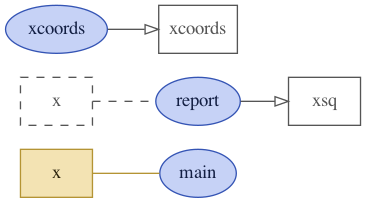

In [7]:
toy_seir.visualize(show_inputs=True, show_variables=True)

----

Now, let's test a minimal implementation using a `current_counts` matrix in `xarray-simlab`. In this example, the array only has 2 dimensions: a time dimension and an age group dimension.

In [77]:
# Process definitions

COUNTS_DIMS = ('age_group', 'risk_group', 'compartment', 'vertex')

@xs.process
class DefineCoords:
    """Example process that generates coordinates for each dimension in the counts array (except time).
    """
    
    age_group = xs.index(dims='age_group')
    risk_group = xs.index(dims='risk_group')
    compartment = xs.index(dims='compartment')
    vertex = xs.index(dims='vertex')
        
    def initialize(self):
        """
        """
        self.age_group = ['0-4', '5-17', '18-49', '50-64', '65+']
        self.risk_group = ['low', 'high']
        self.compartment = ['S', 'E', 'I', 'R']
        self.vertex = range(4)

    
@xs.process
class ToySEIR:
    
    # current counts
    delta_counts = xs.group('delta_counts')
    counts = xs.variable(
        dims=COUNTS_DIMS,
        encoding=dict(
            # `chunks` is not read here
            # chunks=[None, 1, None, 4],
            dtype='int32'
        ),
        intent='inout')
        
    def run_step(self):
        """
        """
        # print(f"running ToySEIR.run_step")
        
        # Calculate the net change in counts for this timestep
        self._delta_sum = sum((v for v in self.delta_counts))
    
    def finalize_step(self):
        # Apply all deltas calculated during this timestep
        self.counts += self._delta_sum
        
       
@xs.process
class VxSpecific:
    """Example of a process that modifies `count` based on
    the value of the `vertex` coordinate.
    """
    
    counts = xs.foreign(ToySEIR, 'counts', intent='in')
    vx_tensor = xs.variable(groups=['delta_counts'], intent='out')
    
    # In case we need timestep information
    # @xs.runtime(args='step')
    def run_step(self):
        vx_coords = self.counts.coords['vertex'].copy()
        self.vx_tensor = vx_coords
    
@xs.process
class ToyDelta:
    """Example process that defines a static scalar
    in the `delta_counts` group.
    """
    
    scalar = xs.variable(groups=['delta_counts'], intent='out', static=True)
    transmission = xs.variable(dims=COUNTS_DIMS, groups=['delta_counts'], intent='out', static=True)
    counts = xs.foreign(ToySEIR, 'counts', intent='in')
    
    def initialize(self):
        self.scalar = 0
        self.transmission = xr.zeros_like(self.counts)
        
        
@xs.process
class InitCounts:
    """Example process that initializes the current counts array
    of zeros based on input coordinates.
    """
    
    counts = xs.foreign(ToySEIR, 'counts', intent='out')
    age_group = xs.foreign(DefineCoords, 'age_group')
    risk_group = xs.foreign(DefineCoords, 'risk_group')
    compartment = xs.foreign(DefineCoords, 'compartment')
    vertex = xs.foreign(DefineCoords, 'vertex')
    
    def initialize(self):
        self.counts = xr.DataArray(
            data=0,
            dims=COUNTS_DIMS,
            coords={
                'age_group': self.age_group,
                'risk_group': self.risk_group,
                'compartment': self.compartment,
                'vertex': self.vertex
            }
        )

In [78]:
# Model definition
toy_seir = xs.Model(dict(
    init=InitCounts,
    main=ToySEIR,
    operator=ToyDelta,
    seir=VxSpecific,
    coords=DefineCoords
))

# Use the model
in_ds = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(700)
    },
    input_vars={
        # 'main__counts': 0,
        # 'operator__beta': 1
    },
    output_vars={
        'main__counts': 'step',
    }
)
out_ds = in_ds.xsimlab.run(model=toy_seir)
out_ds

<xarray.Dataset>
Dimensions:       (age_group: 5, compartment: 4, risk_group: 2, step: 700, vertex: 4)
Coordinates:
  * age_group     (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
  * compartment   (compartment) <U1 'S' 'E' 'I' 'R'
  * risk_group    (risk_group) <U4 'low' 'high'
  * step          (step) int64 0 1 2 3 4 5 6 7 ... 693 694 695 696 697 698 699
  * vertex        (vertex) int64 0 1 2 3
Data variables:
    main__counts  (step, age_group, risk_group, compartment, vertex) int32 0 ...

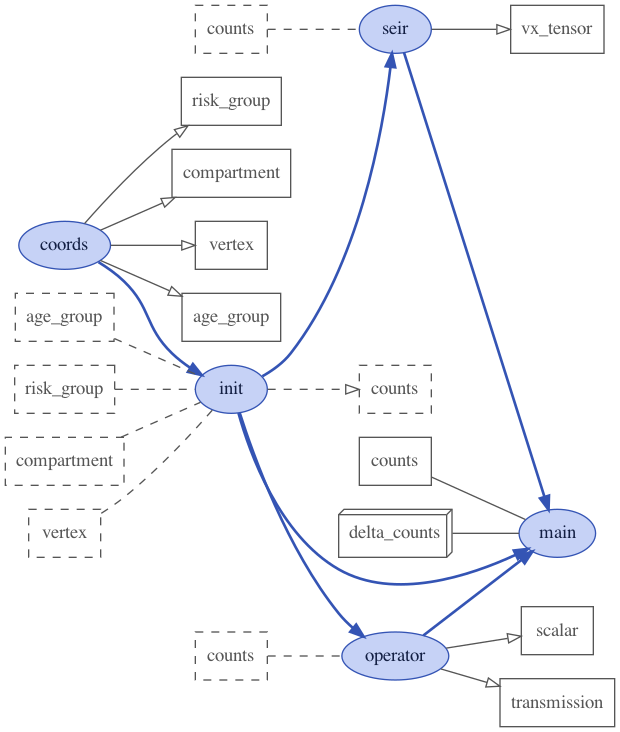

In [57]:
toy_seir.visualize(show_inputs=True, show_variables=True)

### Quickly remind myself what these arrays actually look like...

In [11]:
da = xr.open_dataarray('../../SEIR-city/data/20200701_safegraph_ingest.nc')
da

<xarray.DataArray (time: 700, node: 20, age_group: 5, risk_group: 2, value_type: 14, compartment: 16)>
[31360000 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 2020-02-16 ... 2020-04-26
  * node         (node) int32 1208361472 1208361473 ... 1208361496 1208361497
  * compartment  (compartment) object 'S' 'E' 'Pa' ... 'Py2Iy' 'Iy2Ih' 'H2D'
  * value_type   (value_type) object 'count' 'beta0' ... 'rho' 'deterministic'
  * age_group    (age_group) object '0-4' '5-17' '18-49' '50-64' '65+'
  * risk_group   (risk_group) object 'low' 'high'

In [12]:
da.coords['compartment']

<xarray.DataArray 'compartment' (compartment: 16)>
array(['S', 'E', 'Pa', 'Py', 'Ia', 'Iy', 'Ih', 'R', 'D', 'E2P', 'E2Py', 'P2I',
       'Pa2Ia', 'Py2Iy', 'Iy2Ih', 'H2D'], dtype=object)
Coordinates:
  * compartment  (compartment) object 'S' 'E' 'Pa' ... 'Py2Iy' 'Iy2Ih' 'H2D'

# 2. Does this implementation of SEIR play well with Dask and Zarr?

ENH 10/6/2020

The above model appears to be working as expected, and lays out a tentative spec for what this `episimlab` framework would look like. Basically, we have some initializing processes such as `InitCounts` and `DefineCoords`, which do the same job as `BaseAccessor`s in v2. The `ToySEIR` process serves the same function as the `SimTask` in v2, and a `ToyDelta` process likens to the `ModelExecutor` in that it wraps around the actual simulation code.

It is easy to see how this type of framework could be easily extended, and the entire process of building a new workflow from the ground up appears to be quite simple and quick.

The next step is to test `xarray-simlab`s Dask integration. Since all array-like `variable`s are stored as `xarray.DataArray`s under the hood, we will see at least equivalent performance compared to SEIRcity v2.

### Questions I want to answer today

1. If we `chunk` the input Dataset on different axes, does the underlying `counts` DataArray also get chunked?
2. How can we leverage `zarr` to manage memory usage?
    * Try out the `store` kwarg in method `run`
    * Try out the `encoding` kwarg in `xs.variable`, which is also exposed as a kwarg in the `run` method. This method passes to [`zarr.creation.create`](https://zarr.readthedocs.io/en/stable/api/creation.html#zarr.creation.create).
4. Test how `xarray-simlab` leverages parallelism in general
    * Hypothesis: for the DAG `{A, C}, {B, C}`, processes `A` and `B` run concurrently.
    * Is there a way to **dynamically** allocate tasks in `xarray-simlab`? e.g. `A` and `B` would each get a `chunk` of the input Dataset

In [13]:
# Number 1

in_ds = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(700)
    },
    input_vars={},
    output_vars={
        'main__counts': 'step',
    }
# Doesn't actually do anything without any data variables
# in the input Dataset
).chunk(dict(step=1))

out_ds = in_ds.xsimlab.run(model=toy_seir)
out_ds

<xarray.Dataset>
Dimensions:       (age_group: 5, compartment: 4, risk_group: 2, step: 700, vertex: 4)
Coordinates:
  * age_group     (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
  * compartment   (compartment) <U1 'S' 'E' 'I' 'R'
  * risk_group    (risk_group) <U4 'low' 'high'
  * step          (step) int64 0 1 2 3 4 5 6 7 ... 693 694 695 696 697 698 699
  * vertex        (vertex) int64 0 1 2 3
Data variables:
    main__counts  (step, age_group, risk_group, compartment, vertex) int32 0 ...

----
Now, let's test out the `zarr` integration:

In [14]:
# Number 2

in_ds = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(700)
    },
    input_vars={},
    output_vars={
        'main__counts': 'step',
    }
)

# How to pass chunks to zarr
encoding=dict(
    main__counts=dict(
        # No chunks for `step` and `risk_group`
        # chunks=[None, 1, None, 4],
        # Chunks for `step` only
        chunks=[1],
        dtype='int64'
    )
)
# encoding = dict()

out_ds = in_ds.xsimlab.run(
    model=toy_seir,
    # must pass `store` kwarg to use zarr backend
    store=zarr.TempStore(),
    encoding=encoding
)
out_ds

,Array,Chunk
Bytes,896.00 kB,1.28 kB
Shape,"(700, 5, 2, 4, 4)","(1, 5, 2, 4, 4)"
Count,701 Tasks,700 Chunks
Type,int64,numpy.ndarray


# Next major question: how would we handle parallelism in a SEIR model?

Let's see if we can use `dask.distributed` via `xarray-simlab` to parallelize SEIR models that are running on different vertices (AKA nodes), each of which is running its own SEIR model. I quickly added a `vertex` dimension above, as well as a `VxSpecific` process that outputs a 1-D tensor that is summed as part of the `delta_counts` group. I should note that making this type of change in `xarray-simlab` is embarrassingly easy.

In [79]:
in_ds = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(20)
    },
    input_vars={},
    output_vars={
        'main__counts': 'step',
    }
)

# How to pass chunks to zarr
encoding=dict(
    main__counts=dict(
        # No chunks for `step` and `risk_group`
        # chunks=[None, 1, None, 4],
        # Chunks for `step` only
        chunks=[None, None, None, None, 4],
        dtype='int64'
    )
)

# Track progress with Dask profilers
with Profiler() as prof:
# with ResourceProfiler(dt=0.25) as prof:
    out_ds = in_ds.xsimlab.run(
        model=toy_seir,
        parallel=True,
        # parallel=False,
        scheduler='threads',
        # must pass `store` kwarg to use zarr backend
        store=zarr.TempStore(),
        encoding=encoding
    )
prof.visualize(show=True, save=False)
out_ds

<xarray.Dataset>
Dimensions:       (age_group: 5, compartment: 4, risk_group: 2, step: 20, vertex: 4)
Coordinates:
  * age_group     (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
  * compartment   (compartment) <U1 'S' 'E' 'I' 'R'
  * risk_group    (risk_group) <U4 'low' 'high'
  * step          (step) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * vertex        (vertex) int64 0 1 2 3
Data variables:
    main__counts  (step, age_group, risk_group, compartment, vertex) int64 dask.array<chunksize=(20, 5, 2, 4, 4), meta=np.ndarray>

We get a minor time improvement using `parallel=True`, but looking at the Dask `Profiler`, no processes are run concurrently, even when they are on separate threads.

I suspect this is because my hypothesis above is correct: for the DAG `{A, C}, {B, C}`, only processes `A` and `B` run concurrently.

In [115]:
@xs.process
class ToyA:
    
    var_a = xs.variable(intent='out')
    
    def run_step(self):
        self.var_a = 1
        sleep(1)
    
    def finalize(self):
        pass
        
@xs.process
class ToyB:
    
    var_b = xs.variable(intent='out')
    
    def run_step(self):
        self.var_b = 4
        sleep(1)
    
    def finalize(self):
        pass
        
@xs.process
class ToyC:
    
    var_a = xs.foreign(ToyA, 'var_a', intent='in')
    var_b = xs.foreign(ToyB, 'var_b', intent='in')
    var_c = xs.variable(intent='out')
    
    def run_step(self):
        self.var_c = self.var_a + self.var_b
        
    def finalize(self):
        pass

In [119]:
# Model definition
toy_test = xs.Model(dict(
    a=ToyA, b=ToyB, c=ToyC
))

in_ds = xs.create_setup(
    model=toy_test,
    clocks={
        'step': range(10)
    },
    input_vars={},
    output_vars={
        'c__var_c': 'step'
    }
)

# How to pass chunks to zarr
encoding=dict(
    c__var_c=dict(
        # chunks=[None, None, None, None, 4],
        dtype='int64'
    )
)

# Track progress with Dask profilers
with Profiler() as prof:
# with ResourceProfiler(dt=0.25) as prof:
    out_ds = in_ds.xsimlab.run(
        model=toy_test,
        # parallel=True,
        parallel=True,
        # scheduler='threads',
        # store=zarr.TempStore(),
        # encoding=encoding
    )
prof.visualize(show=True, save=False)
out_ds

<xarray.Dataset>
Dimensions:   (step: 10)
Coordinates:
  * step      (step) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    c__var_c  (step) int64 5 5 5 5 5 5 5 5 5 5

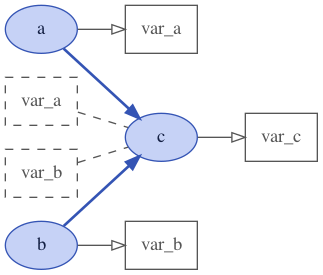

In [117]:
toy_test.visualize(show_variables=True)

Indeed, we see that processes `A` and `B` are run concurrently in this case.

Note that this is not the only way to leverage thread parallelism in the SEIR model; I could simply use OpenMP or `multiprocessing` in the SEIR engine, and then wrap the call to the engine with `xarray-simlab` running serially. But if we allow Dask to handle **all** the resource allocation, we'll probably remove some pain points in the future.